In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display








#
def planegauss(shape, w = 1/2): # function to generate a gaussian across a 2d array, used for gaussian initial condition
    npx = np.linspace( -2, 2, shape[0] )
    npy = np.linspace( -2, 2, shape[1] )
    npxx, npyy = np.meshgrid(npx, npy)
    h = np.exp( -np.e * ( npxx*npxx + npyy*npyy ) / (w*w) )
    return (h)




def lingauss(shape, w = 1/2):
    npx = np.linspace( -2, 2, shape[0] )
    npy = np.linspace( -2, 2, shape[1] )
    npxx, npyy = np.meshgrid(npx, npy)
    h = np.exp( -np.e * ( npxx*npxx ) / (w*w) )
    return (h)





#

In [2]:
#



dx, dy = 100, 100 # meters
sizex, sizey = 1000, 1000 # grid squares (dx)
g = 10 # m/s/s

sealevel = 1000 # m
distsz = 1 # size of the surface disturbance



#initial condition constants
B = np.zeros((sizex, sizey))
H = sealevel - B
N = np.zeros((sizex, sizey)) # eta
N = distsz*lingauss((sizex, sizey), 1/4) # intial condition
U = np.zeros((sizex, sizey)) # global x vel array
V = np.zeros((sizex, sizey)) # global y vel array


#

In [3]:
#



# useful math functions

def partial(a, ax):
    partial = ( np.roll(a, -1, ax) - np.roll(a, 1, ax) ) / (2*(dx, dy)[ax]) # f(x+dx) - f(x) / dx
    return (partial)
def d_dx(a):
    ddx = -partial(a, 0)
    ddx[0] = 0#np.zeros(ddx.shape[0])#ddx[1] # first row is roll-over nonsense
    ddx[-1] = 0#np.zeros(ddx.shape[0])#ddx[-2] # last row rollover nonsense
    return ddx
def d_dy(a):
    ddy = -partial(a, 1)
    ddy[:,0] = 0#np.zeros(ddy.shape[1])#ddy[:,1] # first collumn is roll-over nonsense
    ddy[:,-1] = 0#np.zeros(ddy.shape[1])#ddy[:,-2] # last col roll over nonsense
    return ddy
def div(u, v):
#     div = (np.roll(d_dx(u), 1, 0)+np.roll(d_dy(v), 1, 1)) # has asymetry wrong grid
    div = d_dy(v) + d_dx(u)
    return div







#

In [4]:
#


def timestep(h, n, u, v, dt): # step one iteration into the future
    n0 = n - ( d_dx((h+n)*u) +  d_dy((h+n)*v) )*dt  #dn/dt = -div((n+h)u,(n+h)v])
    u0 = u - ( g*d_dx(n) )*dt  #                     du/dt = -g*dn/dx              u*d_dx(u)+v*d_dy(u)+
    v0 = v - ( g*d_dy(n) )*dt  #                     dv/dt = -g*dn/dy
    return n0, u0, v0



#

In [5]:
#


# display functions

def dispimg(a):
    imgplot = plt.imshow(a, 'Oranges')
    plt.colorbar()
    return

def disp3d(a, b, xlim, ylim, zlim, fsize = (10, 10), ires = (10, 10)):
    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(len(a))
    xx, yy = np.meshgrid(x, y)
    # Plot wireframe.
    ax.plot_wireframe(xx, yy, a, rstride=int(ires[0]), cstride=int(ires[1]))
    ax.plot_wireframe(xx, yy, b, rstride=int(ires[0]*10), cstride=int(ires[1]*10))
    
    ax = plt.gca()
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    
    plt.show()
    return

def vect(u, v, xlim, ylim, size = (10, 10), arwspar = (1, 1), arwsz = 1):
    arwspar = (int(arwspar[0]), int(arwspar[1]))
    fig, ax = plt.subplots(figsize=size)
    xx, yy = np.meshgrid(np.arange(u.shape[0]), np.arange(u.shape[1]))
    xxsp = xx[::arwspar[0],::arwspar[1]]
    yysp = yy[::arwspar[0],::arwspar[1]]
    usp = u[::arwspar[0],::arwspar[1]]
    vsp = v[::arwspar[0],::arwspar[1]]
    m = np.hypot(usp, vsp)
    ax.quiver(xxsp, yysp, vsp, usp, m, scale = 1/arwsz)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    return



#

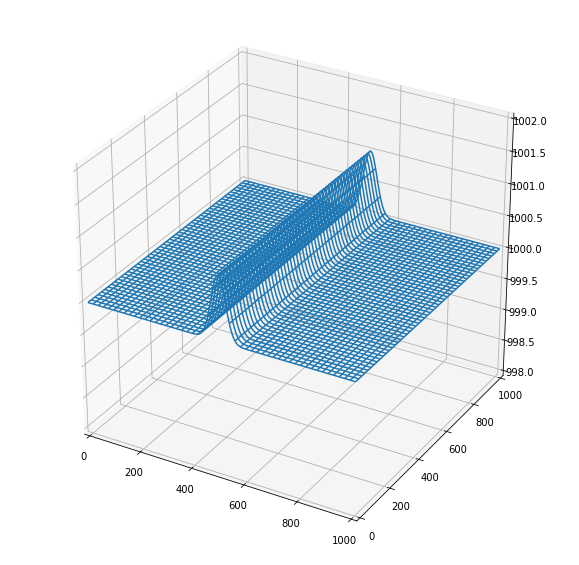

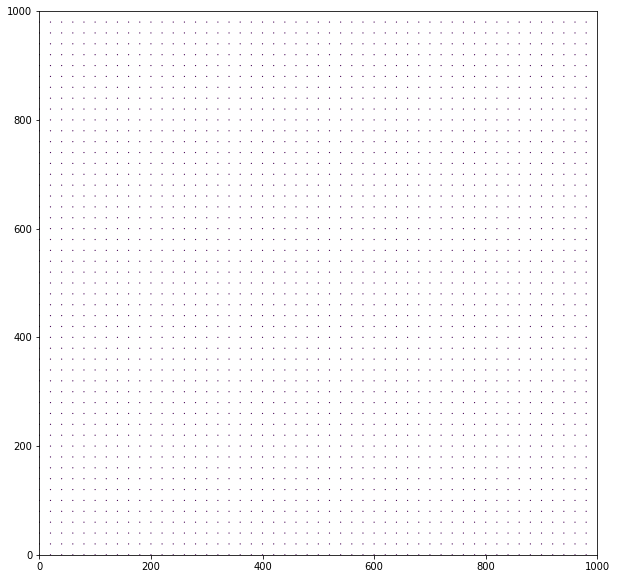

In [6]:
#


#display initial conditions
disp3d(B+H+N, B, [0, sizex], [0, sizey], [sealevel-2*distsz, sealevel+2*distsz], (10, 10), (sizex/50, sizey/50))
vect(U, V, [0, sizex], [0, sizey], (10, 10), (sizex/50, sizey/50), 1)


#

In [7]:
#



# simulate through time


# displays resulting water height after time t
def simulate(h, n, u, v, t, dt = 1):
    # dont try if timstep is zero or negative
    if (dt <= 0):
        return False
    
    # iterate t times with interval size dt
    itr = 0
    while (itr < t):
        n, u, v = timestep(h, n, u, v, dt) # pushes N, U, V one step into the future
        itr += dt
    
    return n, u ,v


#

In [8]:
#
 
# runs and displays simulation
def rendersim(t, dt):
    
    # run simulation with initial condition inputs and t seconds
    n, u, v = simulate(H, N, U, V, t, dt)
    h = np.array(H)
    b = np.array(B)
    
    print('integral dxdy: ')
    print(np.sum(h+n))
    print('total divergence: ')
    print(np.sum(div(u, v)))
    
    # display water height
    disp3d(h+n, b, [0, sizex], [0, sizey], [sealevel-2*distsz, sealevel+2*distsz], (16, 16), (sizex/80, sizey/80))
    
    # display vector feild of velocity
    vect(u, v, [0, sizex], [0, sizey], (16, 16), (20, 20), 1)
    return

#

In [14]:
#


# control and interact with sim
controls = interactive(rendersim, # runs simulate() on initial conditions
                       {'manual' : True, 'manual_name' : 'run simulation'}, # dont run until I say so
                       t = widgets.IntSlider(min = 0, max = 1000, value = 100), # time elapsed
                       dt = 0.5#widgets.FloatSlider(min = 0.1, max = 10, step = 0.01, value = 1.0) # time interval
                       )
display(controls)



#

interactive(children=(IntSlider(value=100, description='t', max=1000), FloatSlider(value=0.5, description='dt'…

In [10]:
#

h = np.mean(H)

# convergence plot
# plot difference between exact and computed solution
t0 = 50 # time of first sample
Dt = 20 # seconds between first and second sample
h1, u1, v1 = simulate(H,N,U,V,t0,0.5)
h2, u2, v2 = simulate(H,N,U,V,t0+Dt,0.5)

p1 = np.argmax(h1) * dy # location of first peak in first sample in meters
p2 = np.argmax(h2) * dy # location of first peak in second sample in meters

ws = ( p1 - p2 ) / (Dt) # average speed of first peak/wave over time interval Dt

print("computed wave speed: " + str(ws))
print("expected exact wave speeed: " + str(np.sqrt(g*h)))

#

computed wave speed: 595.0
expected exact wave speeed: 100.0


In [11]:
import unittest

# unit test of differential functions
class testdifferential(unittest.TestCase):
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # 2d array
        self.ddthreshold = 1E-16
        
    def test_ddx(self):
        da = d_dx(self.a)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)
        
        
unittest.main(argv=['first-arg-is-ignored'], exit=False)

#You can pass further arguments in the argv list, e.g.

#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


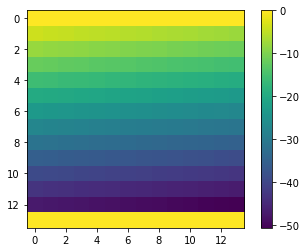

In [12]:
b = np.arange(196)
b = b.reshape(14, 14)
b = b*b #x^2 array

fig, ax = plt.subplots()
adif = plt.imshow(d_dx(b)) # should print a constange in x with odd boundaries
plt.colorbar()